# Quantopian Alpha Factor Library

This notebook contains a mumber of alpha factor candidates that we can use as features in ML models on the Quantopian platform.

In [277]:
import pandas as pd
import numpy as np
from time import time
import talib
import re
from statsmodels.api import OLS
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.preprocessing import StandardScaler

from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline, factors, filters, classifiers
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import (Latest, 
                                         Returns, 
                                         AverageDollarVolume, 
                                         SimpleMovingAverage,
                                         EWMA,
                                         BollingerBands,
                                         CustomFactor,
                                         MarketCap,
                                        SimpleBeta)
from quantopian.pipeline.filters import QTradableStocksUS, StaticAssets
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from empyrical import max_drawdown, sortino_ratio

import seaborn as sns
import matplotlib.pyplot as plt

## Data Sources

In [3]:
################
# Fundamentals #
################

# Morningstar fundamentals (2002 - Ongoing)
# https://www.quantopian.com/help/fundamentals
from quantopian.pipeline.data import Fundamentals

#####################
# Analyst Estimates #
#####################

# Earnings Surprises - Zacks (27 May 2006 - Ongoing)
# https://www.quantopian.com/data/zacks/earnings_surprises
from quantopian.pipeline.data.zacks import EarningsSurprises
from quantopian.pipeline.factors.zacks import BusinessDaysSinceEarningsSurprisesAnnouncement

##########
# Events #
##########

# Buyback Announcements - EventVestor (01 Jun 2007 - Ongoing)
# https://www.quantopian.com/data/eventvestor/buyback_auth
from quantopian.pipeline.data.eventvestor import BuybackAuthorizations
from quantopian.pipeline.factors.eventvestor import BusinessDaysSinceBuybackAuth

# CEO Changes - EventVestor (01 Jan 2007 - Ongoing)
# https://www.quantopian.com/data/eventvestor/ceo_change
from quantopian.pipeline.data.eventvestor import CEOChangeAnnouncements

# Dividends - EventVestor (01 Jan 2007 - Ongoing)
# https://www.quantopian.com/data/eventvestor/dividends
from quantopian.pipeline.data.eventvestor import (
    DividendsByExDate,
    DividendsByPayDate,
    DividendsByAnnouncementDate,
)
from quantopian.pipeline.factors.eventvestor import (
    BusinessDaysSincePreviousExDate,
    BusinessDaysUntilNextExDate,
    BusinessDaysSinceDividendAnnouncement,
)

# Earnings Calendar - EventVestor (01 Jan 2007 - Ongoing)
# https://www.quantopian.com/data/eventvestor/earnings_calendar
from quantopian.pipeline.data.eventvestor import EarningsCalendar
from quantopian.pipeline.factors.eventvestor import (
    BusinessDaysUntilNextEarnings,
    BusinessDaysSincePreviousEarnings
)

# 13D Filings - EventVestor (01 Jan 2007 - Ongoing)
# https://www.quantopian.com/data/eventvestor/_13d_filings
from quantopian.pipeline.data.eventvestor import _13DFilings
from quantopian.pipeline.factors.eventvestor import BusinessDaysSince13DFilingsDate

#############
# Sentiment #
#############

# News Sentiment - Sentdex Sentiment Analysis (15 Oct 2012 - Ongoing)
# https://www.quantopian.com/data/sentdex/sentiment
from quantopian.pipeline.data.sentdex import sentiment

### Parameters

In [4]:
# trading days per period
MONTH = 21
YEAR = 12 * MONTH

In [5]:
START = '2014-01-01'
END = '2015-12-31'

## Universe

In [6]:
def Q100US():
    return filters.make_us_equity_universe(
        target_size=100,
        rankby=factors.AverageDollarVolume(window_length=200),
        mask=filters.default_us_equity_universe_mask(),
        groupby=classifiers.fundamentals.Sector(),
        max_group_weight=0.3,
        smoothing_func=lambda f: f.downsample('month_start'),
    )

In [7]:
# UNIVERSE = StaticAssets(symbols(['MSFT', 'AAPL']))
UNIVERSE = Q100US()

## Helper Functions

In [8]:
class AnnualizedData(CustomFactor):
    # Get the sum of the last 4 reported values
    window_length = 260

    def compute(self, today, assets, out, asof_date, values):
        for asset in range(len(assets)):
            # unique asof dates indicate availability of new figures
            _, filing_dates = np.unique(asof_date[:, asset], return_index=True)
            quarterly_values = values[filing_dates[-4:], asset]
            # ignore annual windows with <4 quarterly data points
            if len(~np.isnan(quarterly_values)) != 4:    
                out[asset] = np.nan
            else:
                out[asset] = np.sum(quarterly_values)

In [9]:
class AnnualAvg(CustomFactor):
    window_length = 252
    
    def compute(self, today, assets, out, values):
        out[:] = (values[0] + values[-1])/2

In [10]:
def factor_pipeline(factors):
    start = time()
    pipe = Pipeline({k: v(mask=UNIVERSE).rank() for k, v in factors.items()},
                    screen=UNIVERSE)
    result = run_pipeline(pipe, start_date=START, end_date=END)
    return result, time() - start

## Alpha Factors

### Value Factors

In [11]:
class ValueFactors:
    """Definitions of factors for cross-sectional trading algorithms"""
    
    @staticmethod
    def PriceToSalesTTM(**kwargs):
        """Last closing price divided by sales per share"""        
        return Fundamentals.ps_ratio.latest

    @staticmethod
    def PriceToEarningsTTM(**kwargs):
        """Closing price divided by earnings per share (EPS)"""
        return Fundamentals.pe_ratio.latest
 
    @staticmethod
    def PriceToDilutedEarningsTTM(mask):
        """Closing price divided by diluted EPS"""
        last_close = USEquityPricing.close.latest
        diluted_eps = AnnualizedData(inputs = [Fundamentals.diluted_eps_earnings_reports_asof_date,
                                               Fundamentals.diluted_eps_earnings_reports],
                                     mask=mask)
        return last_close / diluted_eps

    @staticmethod
    def PriceToForwardEarnings(**kwargs):
        """Price to Forward Earnings"""
        return Fundamentals.forward_pe_ratio.latest
    
    @staticmethod
    def DividendYield(**kwargs):
        """Dividends per share divided by closing price"""
        return Fundamentals.trailing_dividend_yield.latest

    @staticmethod
    def PriceToFCF(mask):
        """Price to Free Cash Flow"""
        last_close = USEquityPricing.close.latest
        fcf_share = AnnualizedData(inputs = [Fundamentals.fcf_per_share_asof_date,
                                             Fundamentals.fcf_per_share],
                                   mask=mask)
        return last_close / fcf_share

    @staticmethod
    def PriceToOperatingCashflow(mask):
        """Last Close divided by Operating Cash Flows"""
        last_close = USEquityPricing.close.latest
        cfo_per_share = AnnualizedData(inputs = [Fundamentals.cfo_per_share_asof_date,
                                                 Fundamentals.cfo_per_share],
                                       mask=mask)        
        return last_close / cfo_per_share

    @staticmethod
    def PriceToBook(mask):
        """Closing price divided by book value"""
        last_close = USEquityPricing.close.latest
        book_value_per_share = AnnualizedData(inputs = [Fundamentals.book_value_per_share_asof_date,
                                              Fundamentals.book_value_per_share],
                                             mask=mask)        
        return last_close / book_value_per_share


    @staticmethod
    def EVToFCF(mask):
        """Enterprise Value divided by Free Cash Flows"""
        fcf = AnnualizedData(inputs = [Fundamentals.free_cash_flow_asof_date,
                                       Fundamentals.free_cash_flow],
                             mask=mask)
        return Fundamentals.enterprise_value.latest / fcf

    @staticmethod
    def EVToEBITDA(mask):
        """Enterprise Value to Earnings Before Interest, Taxes, Deprecation and Amortization (EBITDA)"""
        ebitda = AnnualizedData(inputs = [Fundamentals.ebitda_asof_date,
                                          Fundamentals.ebitda],
                                mask=mask)

        return Fundamentals.enterprise_value.latest / ebitda

    @staticmethod
    def EBITDAYield(mask):
        """EBITDA divided by latest close"""
        ebitda = AnnualizedData(inputs = [Fundamentals.ebitda_asof_date,
                                          Fundamentals.ebitda],
                                mask=mask)
        return USEquityPricing.close.latest / ebitda

In [12]:
VALUE_FACTORS = {
    'DividendYield'            : ValueFactors.DividendYield,
    'EBITDAYield'              : ValueFactors.EBITDAYield,
    'EVToEBITDA'               : ValueFactors.EVToEBITDA,
    'EVToFCF'                  : ValueFactors.EVToFCF,
    'PriceToBook'              : ValueFactors.PriceToBook,
    'PriceToDilutedEarningsTTM': ValueFactors.PriceToDilutedEarningsTTM,
    'PriceToEarningsTTM'       : ValueFactors.PriceToEarningsTTM,
    'PriceToFCF'               : ValueFactors.PriceToFCF,
    'PriceToForwardEarnings'   : ValueFactors.PriceToForwardEarnings,
    'PriceToOperatingCashflow' : ValueFactors.PriceToOperatingCashflow,
    'PriceToSalesTTM'          : ValueFactors.PriceToSalesTTM,
}

In [13]:
value_result, t = factor_pipeline(VALUE_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
value_result.info()

/usr/local/lib/python2.7/dist-packages/numpy/lib/arraysetops.py:200: FutureWarning: In the future, NAT != NAT will be True rather than False.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


Pipeline run time 91.12 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50362 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 11 columns):
DividendYield                40772 non-null float64
EBITDAYield                  49823 non-null float64
EVToEBITDA                   49823 non-null float64
EVToFCF                      46400 non-null float64
PriceToBook                  50343 non-null float64
PriceToDilutedEarningsTTM    50215 non-null float64
PriceToEarningsTTM           48956 non-null float64
PriceToFCF                   49133 non-null float64
PriceToForwardEarnings       39607 non-null float64
PriceToOperatingCashflow     50343 non-null float64
PriceToSalesTTM              50362 non-null float64
dtypes: float64(11)
memory usage: 4.6+ MB


### Momentum

In [14]:
class MomentumFactors:
    """Custom Momentum Factors"""
    class PercentAboveLow(CustomFactor):
        """Percentage of current close above low 
        in lookback window of window_length days
        """
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            out[:] = close[-1] / np.min(close, axis=0) - 1

    class PercentBelowHigh(CustomFactor):
        """Percentage of current close below high 
        in lookback window of window_length days
        """
        
        inputs = [USEquityPricing.close]
        window_length = 252
            
        def compute(self, today, assets, out, close):
            out[:] = close[-1] / np.max(close, axis=0) - 1

    @staticmethod
    def make_dx(timeperiod=14):
        class DX(CustomFactor):
            """Directional Movement Index"""
            inputs = [USEquityPricing.high, 
                      USEquityPricing.low, 
                      USEquityPricing.close]
            window_length = timeperiod + 1
            
            def compute(self, today, assets, out, high, low, close):
                out[:] = [talib.DX(high[:, i], 
                                   low[:, i], 
                                   close[:, i], 
                                   timeperiod=timeperiod)[-1] 
                          for i in range(len(assets))]
        return DX  

    @staticmethod
    def make_mfi(timeperiod=14):
        class MFI(CustomFactor):
            """Money Flow Index"""
            inputs = [USEquityPricing.high, 
                      USEquityPricing.low, 
                      USEquityPricing.close,
                      USEquityPricing.volume]
            window_length = timeperiod + 1
            
            def compute(self, today, assets, out, high, low, close, vol):
                out[:] = [talib.MFI(high[:, i], 
                                    low[:, i], 
                                    close[:, i],
                                    vol[:, i],
                                    timeperiod=timeperiod)[-1] 
                          for i in range(len(assets))]
        return MFI           

    @staticmethod
    def make_oscillator(fastperiod=12, slowperiod=26, matype=0):
        class PPO(CustomFactor):
            """12/26-Day Percent Price Oscillator"""
            inputs = [USEquityPricing.close]
            window_length = slowperiod

            def compute(self, today, assets, out, close_prices):
                out[:] = [talib.PPO(close,
                                    fastperiod=fastperiod,
                                    slowperiod=slowperiod, 
                                    matype=matype)[-1]
                         for close in close_prices.T]
        return PPO

    @staticmethod
    def make_stochastic_oscillator(fastk_period=5, slowk_period=3, slowd_period=3, 
                                   slowk_matype=0, slowd_matype=0):                
        class StochasticOscillator(CustomFactor):
            """20-day Stochastic Oscillator """
            inputs = [USEquityPricing.high, 
                      USEquityPricing.low, 
                      USEquityPricing.close]
            outputs = ['slowk', 'slowd']
            window_length = fastk_period * 2
            
            def compute(self, today, assets, out, high, low, close):
                slowk, slowd = [talib.STOCH(high[:, i],
                                            low[:, i],
                                            close[:, i], 
                                            fastk_period=fastk_period,
                                            slowk_period=slowk_period, 
                                            slowk_matype=slowk_matype, 
                                            slowd_period=slowd_period, 
                                            slowd_matype=slowd_matype)[-1] 
                                for i in range(len(assets))]

                out.slowk[:], out.slowd[:] = slowk[-1], slowd[-1]
        return StochasticOscillator
    
    @staticmethod
    def make_trendline(timeperiod=252):                
        class Trendline(CustomFactor):
            inputs = [USEquityPricing.close]
            """52-Week Trendline"""
            window_length = timeperiod

            def compute(self, today, assets, out, close_prices):
                out[:] = [talib.LINEARREG_SLOPE(close, 
                                   timeperiod=timeperiod)[-1] 
                          for close in close_prices.T]
        return Trendline

In [15]:
MOMENTUM_FACTORS = {
    'Percent Above Low'            : MomentumFactors.PercentAboveLow,
    'Percent Below High'           : MomentumFactors.PercentBelowHigh,
    'Price Oscillator'             : MomentumFactors.make_oscillator(),
    'Money Flow Index'             : MomentumFactors.make_mfi(),
    'Directional Movement Index'   : MomentumFactors.make_dx(),
    'Trendline'                    : MomentumFactors.make_trendline()
}

In [16]:
momentum_result, t = factor_pipeline(MOMENTUM_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
momentum_result.info()

Pipeline run time 20.53 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50362 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 6 columns):
Directional Movement Index    50362 non-null float64
Money Flow Index              50362 non-null float64
Percent Above Low             49536 non-null float64
Percent Below High            49536 non-null float64
Price Oscillator              50355 non-null float64
Trendline                     49536 non-null float64
dtypes: float64(6)
memory usage: 2.7+ MB


### Efficiency

In [17]:
class EfficiencyFactors:

    @staticmethod
    def CapexToAssets(mask):
        """Capital Expenditure divided by Total Assets"""
        capex = AnnualizedData(inputs = [Fundamentals.capital_expenditure_asof_date,
                                         Fundamentals.capital_expenditure],
                                     mask=mask)   
        assets = Fundamentals.total_assets.latest
        return - capex / assets

    @staticmethod
    def CapexToSales(mask):
        """Capital Expenditure divided by Total Revenue"""
        capex = AnnualizedData(inputs = [Fundamentals.capital_expenditure_asof_date,
                                         Fundamentals.capital_expenditure],
                                     mask=mask)   
        revenue = AnnualizedData(inputs = [Fundamentals.total_revenue_asof_date,
                                         Fundamentals.total_revenue],
                                     mask=mask)         
        return - capex / revenue
  
    @staticmethod
    def CapexToFCF(mask):
        """Capital Expenditure divided by Free Cash Flows"""
        capex = AnnualizedData(inputs = [Fundamentals.capital_expenditure_asof_date,
                                         Fundamentals.capital_expenditure],
                                     mask=mask)   
        free_cash_flow = AnnualizedData(inputs = [Fundamentals.free_cash_flow_asof_date,
                                         Fundamentals.free_cash_flow],
                                     mask=mask)         
        return - capex / free_cash_flow

    @staticmethod
    def EBITToAssets(mask):
        """Earnings Before Interest and Taxes (EBIT) divided by Total Assets"""
        ebit = AnnualizedData(inputs = [Fundamentals.ebit_asof_date,
                                         Fundamentals.ebit],
                                     mask=mask)   
        assets = Fundamentals.total_assets.latest
        return ebit / assets
    
    @staticmethod
    def CFOToAssets(mask):
        """Operating Cash Flows divided by Total Assets"""
        cfo = AnnualizedData(inputs = [Fundamentals.operating_cash_flow_asof_date,
                                         Fundamentals.operating_cash_flow],
                                     mask=mask)   
        assets = Fundamentals.total_assets.latest
        return cfo / assets 
    
    @staticmethod
    def RetainedEarningsToAssets(mask):
        """Retained Earnings divided by Total Assets"""
        retained_earnings = AnnualizedData(inputs = [Fundamentals.retained_earnings_asof_date,
                                         Fundamentals.retained_earnings],
                                     mask=mask)   
        assets = Fundamentals.total_assets.latest
        return retained_earnings / assets

In [18]:
EFFICIENCY_FACTORS = {
    'CFO To Assets' :EfficiencyFactors.CFOToAssets,
    'Capex To Assets' :EfficiencyFactors.CapexToAssets,
    'Capex To FCF' :EfficiencyFactors.CapexToFCF,
    'Capex To Sales' :EfficiencyFactors.CapexToSales,
    'EBIT To Assets' :EfficiencyFactors.EBITToAssets,
    'Retained Earnings To Assets' :EfficiencyFactors.RetainedEarningsToAssets
    }

In [19]:
efficiency_result, t = factor_pipeline(EFFICIENCY_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
efficiency_result.info()

Pipeline run time 35.88 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50362 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 6 columns):
CFO To Assets                  50351 non-null float64
Capex To Assets                46997 non-null float64
Capex To FCF                   45799 non-null float64
Capex To Sales                 46997 non-null float64
EBIT To Assets                 46635 non-null float64
Retained Earnings To Assets    50349 non-null float64
dtypes: float64(6)
memory usage: 2.7+ MB


### Risk

In [20]:
class RiskFactors:

    @staticmethod
    def LogMarketCap(mask):
        """Log of Market Capitalization log(Close Price * Shares Outstanding)"""
        return np.log(MarketCap(mask=mask))
 
    class DownsideRisk(CustomFactor):
        """Mean returns divided by std of 1yr daily losses (Sortino Ratio)"""
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            ret = pd.DataFrame(close).pct_change()
            out[:] = ret.mean().div(ret.where(ret<0).std())

    @staticmethod
    def MarketBeta(**kwargs):
        """Slope of 1-yr regression of price returns against index returns"""
        return SimpleBeta(target=symbols('SPY'), regression_length=252) 

    class DownsideBeta(CustomFactor):
        """Slope of 1yr regression of returns on negative index returns"""
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            t = len(close)
            assets = pd.DataFrame(close).pct_change()
            
            start_date = (today - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
            spy = get_pricing('SPY', 
                              start_date=start_date, 
                              end_date=today.strftime('%Y-%m-%d')).reset_index(drop=True)
            spy_neg_ret = (spy
                           .close_price
                           .iloc[-t:]
                           .pct_change()
                           .pipe(lambda x: x.where(x<0)))
    
            out[:] = assets.apply(lambda x: x.cov(spy_neg_ret)).div(spy_neg_ret.var())         

    class Vol3M(CustomFactor):
        """3-month Volatility: Standard deviation of returns over 3 months"""

        inputs = [USEquityPricing.close]
        window_length = 63

        def compute(self, today, assets, out, close):
            out[:] = np.log1p(pd.DataFrame(close).pct_change()).std()

In [21]:
RISK_FACTORS = {
    'Log Market Cap' : RiskFactors.LogMarketCap,
    'Downside Risk'  : RiskFactors.DownsideRisk,
    'Index Beta'     : RiskFactors.MarketBeta,
#     'Downside Beta'  : RiskFactors.DownsideBeta,    
    'Volatility 3M'  : RiskFactors.Vol3M,    
}

In [22]:
risk_result, t = factor_pipeline(RISK_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
risk_result.info()

Pipeline run time 46.10 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50362 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 4 columns):
Downside Risk     50362 non-null float64
Index Beta        50079 non-null float64
Log Market Cap    50362 non-null float64
Volatility 3M     50362 non-null float64
dtypes: float64(4)
memory usage: 1.9+ MB


### Growth

In [23]:
def growth_pipeline():
    revenue = AnnualizedData(inputs = [Fundamentals.total_revenue_asof_date,
                                       Fundamentals.total_revenue],
                             mask=UNIVERSE)
    eps = AnnualizedData(inputs = [Fundamentals.diluted_eps_earnings_reports_asof_date,
                                       Fundamentals.diluted_eps_earnings_reports],
                             mask=UNIVERSE)    

    return Pipeline({'Sales': revenue,
                     'EPS': eps,
                     'Total Assets': Fundamentals.total_assets.latest,
                     'Net Debt': Fundamentals.net_debt.latest},
                    screen=UNIVERSE)

In [24]:
start_timer = time()
growth_result = run_pipeline(growth_pipeline(), start_date=START, end_date=END)

for col in growth_result.columns:
    for month in [3, 12]:
        new_col = col + ' Growth {}M'.format(month)
        kwargs = {new_col: growth_result[col].pct_change(month*MONTH).groupby(level=1).rank()}        
        growth_result = growth_result.assign(**kwargs)
print('Pipeline run time {:.2f} secs'.format(time() - start_timer))
growth_result.info()

Pipeline run time 22.21 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50362 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 12 columns):
EPS                        50215 non-null float64
Net Debt                   47413 non-null float64
Sales                      50351 non-null float64
Total Assets               50362 non-null float64
EPS Growth 3M              50152 non-null float64
EPS Growth 12M             49963 non-null float64
Net Debt Growth 3M         47350 non-null float64
Net Debt Growth 12M        47171 non-null float64
Sales Growth 3M            50288 non-null float64
Sales Growth 12M           50099 non-null float64
Total Assets Growth 3M     50299 non-null float64
Total Assets Growth 12M    50110 non-null float64
dtypes: float64(12)
memory usage: 5.0+ MB


### Quality

In [25]:
class QualityFactors:
    
    @staticmethod
    def AssetTurnover(mask):
        """Sales divided by average of year beginning and year end assets"""

        assets = AnnualAvg(inputs=[Fundamentals.total_assets],
                           mask=mask)
        sales = AnnualizedData([Fundamentals.total_revenue_asof_date,
                                Fundamentals.total_revenue], mask=mask)
        return sales / assets
  
    @staticmethod
    def CurrentRatio(mask):
        """Total current assets divided by total current liabilities"""

        assets = Fundamentals.current_assets.latest
        liabilities = Fundamentals.current_liabilities.latest
        return assets / liabilities
    
    @staticmethod
    def AssetToEquityRatio(mask):
        """Total current assets divided by common equity"""

        assets = Fundamentals.current_assets.latest
        equity = Fundamentals.common_stock.latest
        return assets / equity    

    
    @staticmethod
    def InterestCoverage(mask):
        """EBIT divided by interest expense"""

        ebit = AnnualizedData(inputs = [Fundamentals.ebit_asof_date,
                                        Fundamentals.ebit], mask=mask)  
        
        interest_expense = AnnualizedData(inputs = [Fundamentals.interest_expense_asof_date,
                                        Fundamentals.interest_expense], mask=mask)
        return ebit / interest_expense

    @staticmethod
    def DebtToAssetRatio(mask):
        """Total Debts divided by Total Assets"""

        debt = Fundamentals.total_debt.latest
        assets = Fundamentals.total_assets.latest
        return debt / assets
    
    @staticmethod
    def DebtToEquityRatio(mask):
        """Total Debts divided by Common Stock Equity"""

        debt = Fundamentals.total_debt.latest
        equity = Fundamentals.common_stock.latest
        return debt / equity    

    @staticmethod
    def WorkingCapitalToAssets(mask):
        """Current Assets less Current liabilities (Working Capital) divided by Assets"""

        working_capital = Fundamentals.working_capital.latest
        assets = Fundamentals.total_assets.latest
        return working_capital / assets
 
    @staticmethod
    def WorkingCapitalToSales(mask):
        """Current Assets less Current liabilities (Working Capital), divided by Sales"""

        working_capital = Fundamentals.working_capital.latest
        sales = AnnualizedData([Fundamentals.total_revenue_asof_date,
                                Fundamentals.total_revenue], mask=mask)        
        return working_capital / sales          
       
        
    class MertonsDD(CustomFactor):
        """Merton's Distance to Default """
        
        inputs = [Fundamentals.total_assets,
                  Fundamentals.total_liabilities, 
                  libor.value, 
                  USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, tot_assets, tot_liabilities, r, close):
            mertons = []

            for col_assets, col_liabilities, col_r, col_close in zip(tot_assets.T, tot_liabilities.T,
                                                                     r.T, close.T):
                vol_1y = np.nanstd(col_close)
                numerator = np.log(
                        col_assets[-1] / col_liabilities[-1]) + ((252 * col_r[-1]) - ((vol_1y ** 2) / 2))
                mertons.append(numerator / vol_1y)

            out[:] = mertons            

In [26]:
QUALITY_FACTORS = {
    'AssetToEquityRatio'    : QualityFactors.AssetToEquityRatio,
    'AssetTurnover'         : QualityFactors.AssetTurnover,
    'CurrentRatio'          : QualityFactors.CurrentRatio,
    'DebtToAssetRatio'      : QualityFactors.DebtToAssetRatio,
    'DebtToEquityRatio'     : QualityFactors.DebtToEquityRatio,
    'InterestCoverage'      : QualityFactors.InterestCoverage,
    'MertonsDD'             : QualityFactors.MertonsDD,
    'WorkingCapitalToAssets': QualityFactors.WorkingCapitalToAssets,
    'WorkingCapitalToSales' : QualityFactors.WorkingCapitalToSales,
}
    

In [27]:
quality_result, t = factor_pipeline(QUALITY_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
quality_result.info()

Pipeline run time 34.41 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50362 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 9 columns):
AssetToEquityRatio        45176 non-null float64
AssetTurnover             50314 non-null float64
CurrentRatio              45680 non-null float64
DebtToAssetRatio          50080 non-null float64
DebtToEquityRatio         48492 non-null float64
InterestCoverage          35250 non-null float64
MertonsDD                 50362 non-null float64
WorkingCapitalToAssets    45680 non-null float64
WorkingCapitalToSales     45669 non-null float64
dtypes: float64(9)
memory usage: 3.8+ MB


### Payout

In [28]:
class PayoutFactors:

    @staticmethod
    def DividendPayoutRatio(mask):
        """Dividends Per Share divided by Earnings Per Share"""

        dps = AnnualizedData(inputs = [Fundamentals.dividend_per_share_earnings_reports_asof_date,
                                        Fundamentals.dividend_per_share_earnings_reports], mask=mask)  
        
        eps = AnnualizedData(inputs = [Fundamentals.basic_eps_earnings_reports_asof_date,
                                        Fundamentals.basic_eps_earnings_reports], mask=mask)
        return dps / eps
    
    @staticmethod
    def DividendGrowth(**kwargs):
        """Annualized percentage DPS change"""        
        return Fundamentals.dps_growth.latest    

In [29]:
PAYOUT_FACTORS = {
    'Dividend Payout Ratio': PayoutFactors.DividendPayoutRatio,
    'Dividend Growth': PayoutFactors.DividendGrowth
}

In [30]:
payout_result, t = factor_pipeline(PAYOUT_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
payout_result.info()

Pipeline run time 21.85 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50362 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 2 columns):
Dividend Growth          40517 non-null float64
Dividend Payout Ratio    39947 non-null float64
dtypes: float64(2)
memory usage: 1.2+ MB


### Profitability

In [31]:
class ProfitabilityFactors:
    
    @staticmethod
    def GrossProfitMargin(mask):
        """Gross Profit divided by Net Sales"""

        gross_profit = AnnualizedData([Fundamentals.gross_profit_asof_date,
                              Fundamentals.gross_profit], mask=mask)  
        sales = AnnualizedData([Fundamentals.total_revenue_asof_date,
                                Fundamentals.total_revenue], mask=mask)
        return gross_profit / sales   
    
    @staticmethod
    def NetIncomeMargin(mask):
        """Net income divided by Net Sales"""

        net_income = AnnualizedData([Fundamentals.net_income_income_statement_asof_date,
                              Fundamentals.net_income_income_statement], mask=mask)  
        sales = AnnualizedData([Fundamentals.total_revenue_asof_date,
                                Fundamentals.total_revenue], mask=mask)
        return net_income / sales   

In [32]:
PROFITABIILTY_FACTORS = {
    'Gross Profit Margin': ProfitabilityFactors.GrossProfitMargin,
    'Net Income Margin': ProfitabilityFactors.NetIncomeMargin,
    'Return on Equity': Fundamentals.roe.latest,
    'Return on Assets': Fundamentals.roa.latest,
    'Return on Invested Capital': Fundamentals.roic.latest
}

In [33]:
profitability_result, t = factor_pipeline(PAYOUT_FACTORS)
print('Pipeline run time {:.2f} secs'.format(t))
payout_result.info()

Pipeline run time 21.65 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50362 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 2 columns):
Dividend Growth          40517 non-null float64
Dividend Payout Ratio    39947 non-null float64
dtypes: float64(2)
memory usage: 1.2+ MB


In [34]:
# profitability_pipeline().show_graph(format='png')

## Build Dataset

### Get Returns

In [ ]:
lookahead = [1, 5, 10, 20]
returns = run_pipeline(Pipeline({'Returns{}D'.format(i): Returns(inputs=[USEquityPricing.close], 
                                          window_length=i+1, mask=UNIVERSE) for i in lookahead},
                                screen=UNIVERSE),
                       start_date=START, 
                       end_date=END)
return_cols = ['Returns{}D'.format(i) for i in lookahead]
returns.info()

In [166]:
data = pd.concat([returns,
                 value_result,
                 momentum_result,
                 quality_result,
                 payout_result,
                 growth_result,
                 efficiency_result,
                 risk_result], axis=1).sortlevel()
data.index.names = ['date', 'asset']

In [167]:
data['stock'] = data.index.get_level_values('asset').map(lambda x: x.asset_name)

### Remove columns and rows with less than 80% of data availability

In [168]:
rows_before, cols_before = data.shape
data = (data
        .dropna(axis=1, thresh=int(len(data)*.8))
        .dropna(thresh=int(len(data.columns) * .8)))
data = data.fillna(data.median())
rows_after, cols_after = data.shape
print('{:,d} rows and {:,d} columns dropped'.format(rows_before-rows_after, cols_before-cols_after))

2,985 rows and 3 columns dropped


In [169]:
data.sort_index(1).info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 47377 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 52 columns):
AssetToEquityRatio             47377 non-null float64
AssetTurnover                  47377 non-null float64
CFO To Assets                  47377 non-null float64
Capex To Assets                47377 non-null float64
Capex To FCF                   47377 non-null float64
Capex To Sales                 47377 non-null float64
CurrentRatio                   47377 non-null float64
DebtToAssetRatio               47377 non-null float64
DebtToEquityRatio              47377 non-null float64
Directional Movement Index     47377 non-null float64
Dividend Growth                47377 non-null float64
DividendYield                  47377 non-null float64
Downside Risk                  47377 non-null float64
EBIT To Assets                 47377 non-null float64
EBITDAYield                    47377 non-null 

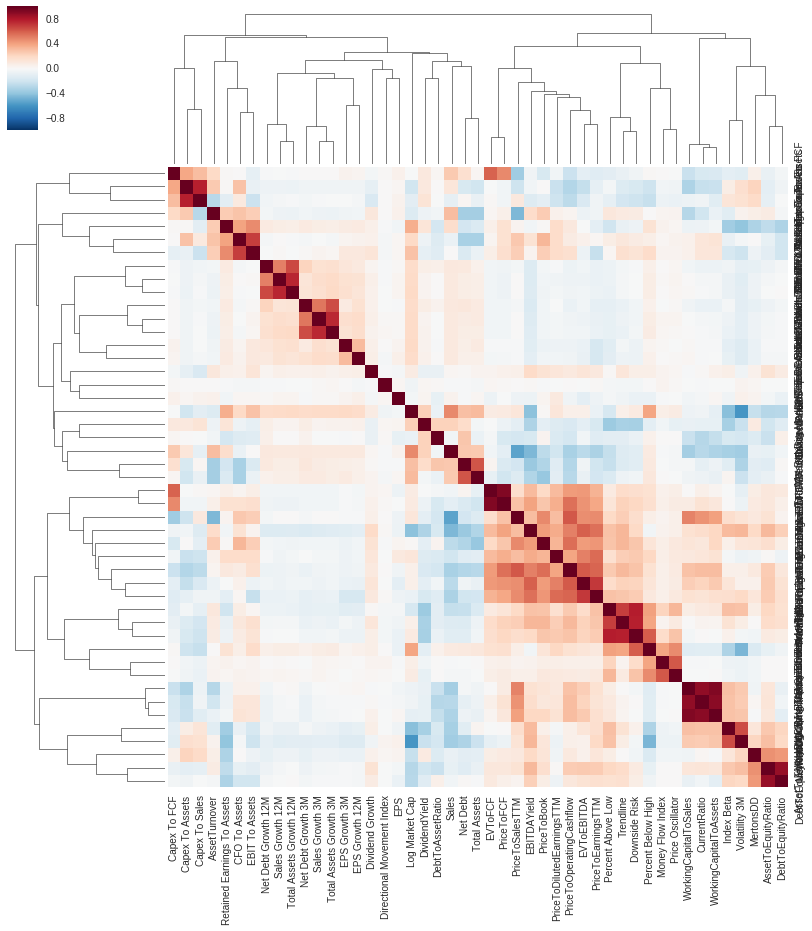

In [170]:
g = sns.clustermap(data.drop(['stock'] + return_cols, axis=1).corr())
plt.gcf().set_size_inches((14,14));

### Prepare Features

In [171]:
X = pd.get_dummies(data.drop(return_cols, axis=1), drop_first=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 47377 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Columns: 182 entries, DividendYield to stock_YELP INC
dtypes: float64(182)
memory usage: 66.1+ MB


### Shifted Returns

In [172]:
y = data.loc[:, return_cols]
shifted_y = []
for col in y.columns:
    t = int(re.search(r'\d+', col).group(0))
    shifted_y.append(y.groupby(level='asset')['Returns{}D'.format(t)].shift(-t).to_frame(col))
y = pd.concat(shifted_y, axis=1)
y.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 47377 entries, (2014-01-02 00:00:00+00:00, Equity(24 [AAPL])) to (2015-12-31 00:00:00+00:00, Equity(47208 [GPRO]))
Data columns (total 4 columns):
Returns1D     47242 non-null float64
Returns5D     46706 non-null float64
Returns10D    46036 non-null float64
Returns20D    44696 non-null float64
dtypes: float64(4)
memory usage: 1.8+ MB


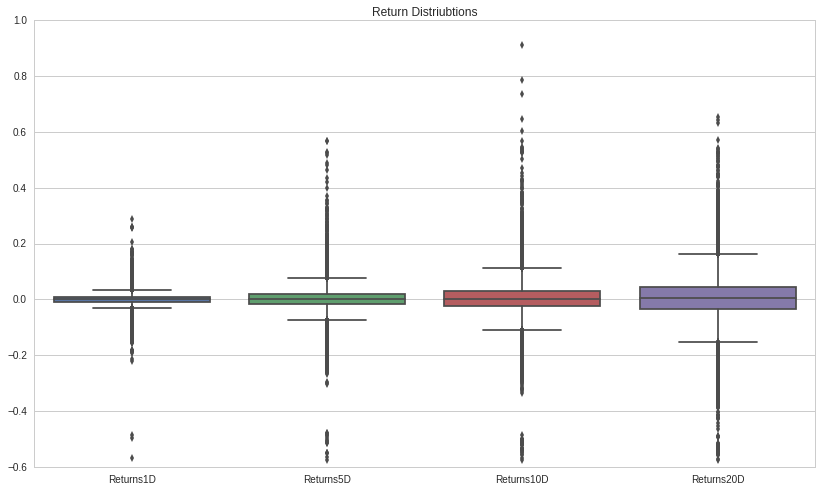

In [175]:
ax = sns.boxplot(y[return_cols])
ax.set_title('Return Distriubtions');

## TA-Lib

In [ ]:
class Technical:
    @staticmethod
    def make_bbands(timeperiod=5, nbdevup=2, nbdevdn=2, matype=0):
        class BBANDS(CustomFactor):
            """Lower, middle, and upper Bollinger Bands"""

            inputs = [USEquityPricing.close]
            outputs = ['upper', 'middle', 'lower']
            window_length = timeperiod

            def compute(self, today, assets, out, close_prices):
                bb = []
                for close in close_prices.T:
                    u, m, l = talib.BBANDS(close, timeperiod=timeperiod, 
                                nbdevup=nbdevup, nbdevdn=nbdevdn, 
                                matype=matype)
                    bb.append((u[-1], m[-1], l[-1]))
                out.upper[:], out.middle[:], out.lower[:] = list(zip(*bb))
        return BBANDS
    
    @staticmethod
    def make_ema(timeperiod=30):
        class EMA(CustomFactor):
            """Double Exponential Moving Average"""
            inputs = [USEquityPricing.close]
            window_length = timeperiod
            
            def compute(self, today, assets, out, close_prices):
                out[:] = [talib.EMA(p, timeperiod=timeperiod)[-1] for p in close_prices.T]
        return EMA 
    
    @staticmethod
    def make_dx(timeperiod=14):
        class DX(CustomFactor):
            """Directional Movement Index"""
            inputs = [USEquityPricing.high, 
                      USEquityPricing.low, 
                      USEquityPricing.close]
            window_length = timeperiod + 1
            
            def compute(self, today, assets, out, high, low, close):
                out[:] = [talib.DX(high[:, i], 
                                   low[:, i], 
                                   close[:, i], 
                                   timeperiod=timeperiod)[-1] 
                          for i in range(len(assets))]
        return DX  
    
    
    @staticmethod
    def make_mfi(timeperiod=14):
        class MFI(CustomFactor):
            """Money Flow Index"""
            inputs = [USEquityPricing.high, 
                      USEquityPricing.low, 
                      USEquityPricing.close,
                      USEquityPricing.volume]
            window_length = timeperiod + 1
            
            def compute(self, today, assets, out, high, low, close, vol):
                out[:] = [talib.MFI(high[:, i], 
                                    low[:, i], 
                                    close[:, i],
                                    vol[:, i],
                                    timeperiod=timeperiod)[-1] 
                          for i in range(len(assets))]
        return MFI

In [ ]:
def test_pipeline():
    stocks = StaticAssets(symbols(['MSFT', 'AAPL']))
#     DX = Technical.make_dx()
    MFI = Technical.make_mfi()
    
    ewma = EWMA(inputs=[USEquityPricing.high],
                        window_length=30, 
                        decay_rate=.2,
                        mask=stocks)
    bb = BollingerBands(window_length=30, k=2, mask=stocks)
    return Pipeline({'adx': Technical.make_dx()(mask=stocks),
                     'mfi': MFI(mask=stocks),
                     'ewma': ewma,
                     'lower': bb.lower,
                     'mid': bb.middle,
                     'up': bb.upper},
                    screen=stocks)

In [ ]:
start_timer = time()
result = run_pipeline(test_pipeline(), 
                      start_date='2018-05-01',
                      end_date='2018-07-31')
print('Pipeline run time {:.2f} secs'.format(time() - start_timer))
result.tail(10)